# Countryrisk

In [1]:
import wbdata
import pandas as pd
import pandas_profiling
import datetime
%config IPCompleter.greedy=True
import pandas_datareader
import urllib3


In [2]:
import quandl
oil = quandl.get("ODA/POILWTI_USD")


In [3]:
oil.head()

,Value
Date,
1980-01-31,37.00
1980-02-29,37.04
1980-03-31,39.52
1980-04-30,39.50
1980-05-31,39.50


In [4]:
oil.tail()

,Value
Date,
2019-06-30,54.677000
2019-07-31,57.508696
2019-08-31,54.839091
2019-09-30,56.857143
2019-10-31,53.979130


# 1- Extracting and Cleaning the Data from IMF, WB and BIS

## Country selection


In [2]:
### fecthing country names from IMF database to get all ISO codes
countrycodes = pd.read_csv('coucodes.csv', delimiter = ';', encoding = "ISO-8859-1")
countrycodes = countrycodes[["IMF Name", "ISO Code", "ISO2 Code"]]
countrycodes.reset_index(level=0, inplace=True)
countrycodes = countrycodes.rename(columns={'IMF Name': 'country'})

countries = ["Brazil",  "Mexico", "India",  "Russia", "Switzerland", "Uruguay",
             "Korea", "Thailand", "Ecuador", "Bolivia", "Costa Rica", "Colombia", "Paraguay",
             "Chile", "South Africa", "Taiwan", "Turkey", "Ukraine", "Nigeria", "Indonesia",
             "Bangladesh", "Philippines", "Pakistan", "Egypt", "Ethiopia", "Vietnam", "Tanzania",
             "Myanmar", "Algeria", "Sudan", "Uganda", "Morocco", "Saudi Arabia", "Uzbekistan", "Malaysia",
             "Afghanistan", "Ghana"]

#Argentina, Venezuela e Iraq are not working - Monthly
#
countrycodes = countrycodes[countrycodes["country"].isin(countries)]

## WB


In [3]:
#downloading data from worldbank

from pandas_datareader import wb

worldbank_data = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_", "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 2010, end = 2020, freq = "M")
worldbank_data2 = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_",  "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 1999, end = 2009, freq = "M")
worldbank_data3 = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_","IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 1990, end = 1998, freq = "M")

worldbank_data = pd.concat([worldbank_data, worldbank_data2])
worldbank_data = pd.concat([worldbank_data, worldbank_data3])

worldbank_data.reset_index(inplace=True)

worldbank_data_conc = pd.merge(worldbank_data, countrycodes, on="country")


## IMF

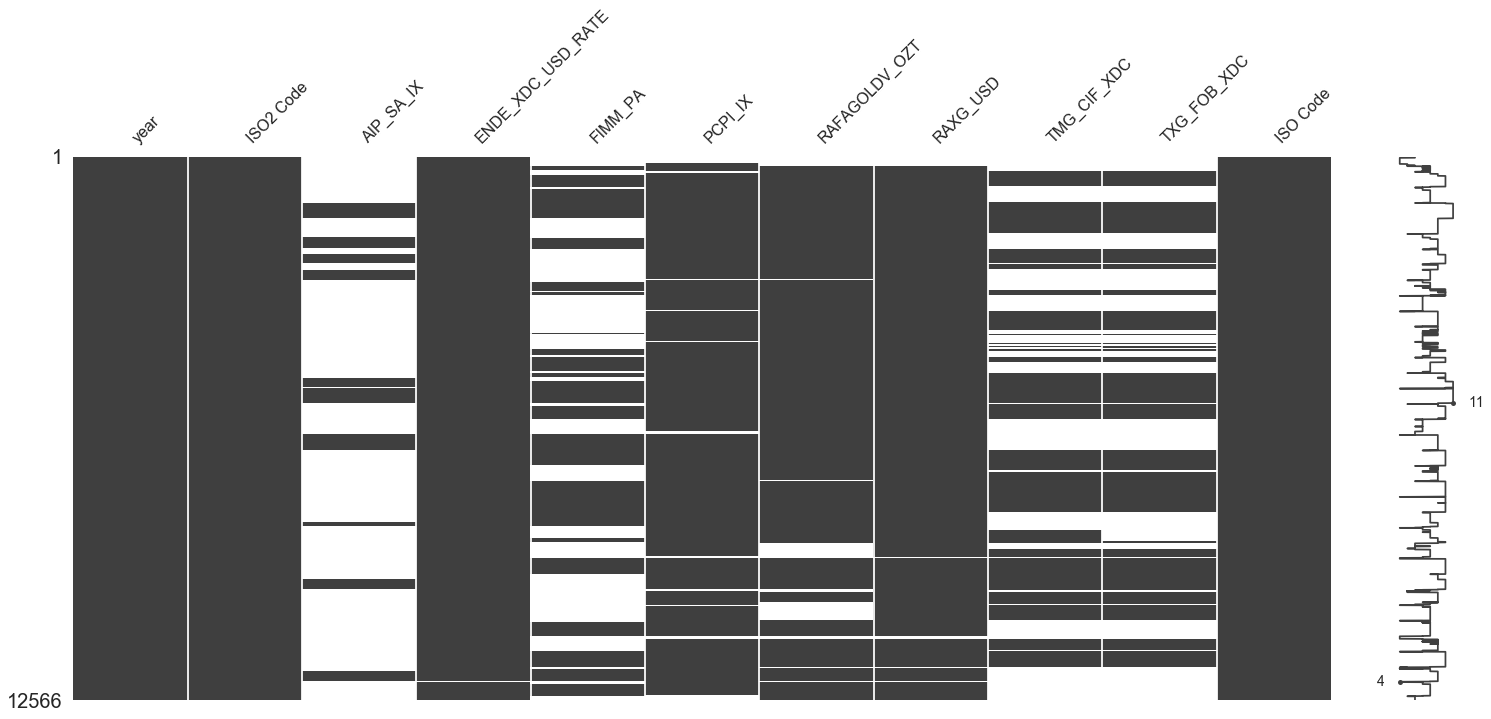

In [4]:
# Example: loading IMF data into pandas
#Monthly data
# Import libraries
import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/M."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')
#Variables
variables = ".RAFAGOLDV_OZT+RAXG_USD+TXG_FOB_XDC+TMG_CIF_XDC+FIMM_PA+PCPI_IX+ENDE_XDC_USD_RATE+AIP_SA_IX.?startPeriod=1990&endPeriod=2030"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.set_index(["@TIME_PERIOD", 'country', 'indicator']).unstack(level=-1)
stack.columns = stack.columns.droplevel(0)

stack.reset_index(inplace=True)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code"})
#Next: Analyze the missing data and data range

import missingno as msno
stack_m = pd.merge(stack, countrycodes[["ISO2 Code", "ISO Code"]], on = "ISO2 Code")
msno.matrix(stack_m)

In [5]:
#The same for price commodities index


# Example: loading IMF data into pandas
#Monthly data
# Import libraries
import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/PCTOT/M."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')
#Variables
variables = ".x_gdp.?startPeriod=1990&endPeriod=2030"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.drop(["indicator"], axis = 1)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code", "@OBS_VALUE" : "PCTOT"})
#Next: Analyze the missing data and data range

stack_m2 = stack.drop_duplicates(["year", "ISO2 Code"])

stack_m3 = pd.merge(stack_m, stack_m2, on = ["ISO2 Code", "year"], how = "left")

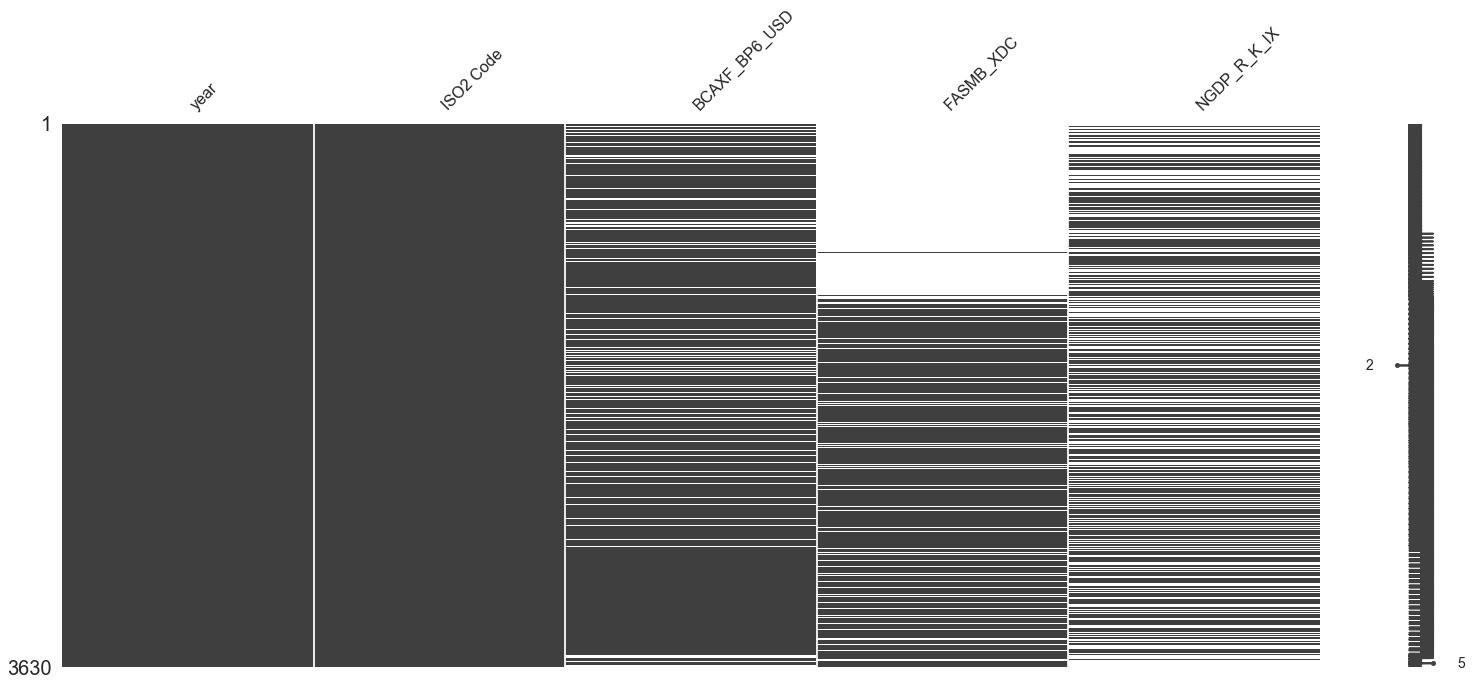

In [6]:
#Quarterly data


import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/Q."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')

#Variables
variables = ".NGDP_R_K_IX+PCTOT+BCAXF_BP6_USD+FASMB_XDC.?startPeriod=1990&endPeriod=2020"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.set_index(["@TIME_PERIOD", 'country', 'indicator']).unstack(level=-1)
stack.columns = stack.columns.droplevel(0)

stack.reset_index(inplace=True)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code"})
#Next: Analyze the missing data and data range

import missingno as msno
msno.matrix(stack)
stack_q = pd.merge(stack, countrycodes[["ISO2 Code"]], on = "ISO2 Code")


In [7]:
# merging monthly and quarterly

stack_q["year"] = pd.to_datetime(stack_q["year"])
stack_m3["year"] = pd.to_datetime(stack_m3["year"])

stack = pd.merge(stack_m3, stack_q, on = ["year", "ISO2 Code"], how = "left")

## OECD

In [8]:
from cif import cif

data_all, subjects_all, measures_all = cif.createDataFrameFromOECD(countries = countrycodes["ISO Code"].tolist(), frequency = 'M', subject = ["SPASTT01"])


Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/AFG.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/DZA.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BGD.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BOL.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BRA.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/BRA.SPASTT01..M/all?dimensionAtObservation=AllDimensions


C:\Users\leomf\Anaconda3\lib\site-packages\cif\cif.py:248: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = [np.repeat(0, dataPart.shape[1]), dataPart.columns.labels[0], dataPart.columns.labels[1]],
C:\Users\leomf\Anaconda3\lib\site-packages\cif\cif.py:249: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  names = ['country', dataPart.columns.names[0], dataPart.columns.names[1]])


Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/CHL.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/CHL.SPASTT01..M/all?dimensionAtObservation=AllDimensions


C:\Users\leomf\Anaconda3\lib\site-packages\cif\cif.py:251: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  dataAll = pd.concat([dataAll, dataPart], axis = 1)


Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/COL.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/COL.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/CRI.SPASTT01..M/all
Error: No available records, please change parameters
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/ECU.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/EGY.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/ETH.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/GHA.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/IND.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/IND.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/IDN.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/

In [9]:
oecd = data_all.stack(level = 0)
oecd.columns = oecd.columns.droplevel(0)
oecd = oecd.reset_index()
oecd = oecd.drop(['GP', 'GY'], axis=1)  
oecd["level_0"] = pd.to_datetime(oecd["level_0"])


In [10]:
full = pd.merge(stack, oecd, left_on = ["ISO Code", "year"], right_on = ["country", "level_0"], how = "left")


## BIS

In [12]:
import certifi
from io import BytesIO
import pandas as pd
from urllib.request import urlopen
from zipfile import ZipFile

z = urlopen('https://www.bis.org/statistics/full_bis_total_credit_csv.zip', cafile = certifi.where())
myzip = ZipFile(BytesIO(z.read())).extract('WEBSTATS_TOTAL_CREDIT_DATAFLOW_csv_col.csv')
credit =pd.read_csv(myzip)


credit = credit[(credit["Borrowing sector"] == "Private non-financial sector") | (credit["Borrowing sector"] == "General government")]
credit = credit[(credit["Lending sector"] == "All sectors")]
credit = credit[(credit["BORROWERS_CTY"].isin(countrycodes["ISO2 Code"]))]
credit = credit[(credit["Unit type"] == "Percentage of GDP")]
credit = credit[(credit["TC_ADJUST"] == "A")]
credit = credit[(credit["Valuation"] == "Market value")]
credit = (credit.set_index(['Borrowing sector', 'BORROWERS_CTY'])
   .rename_axis(['Year'], axis=1)
   .stack()
   .unstack('Borrowing sector')
   .reset_index())
credit = credit.iloc[13:]


C:\Users\leomf\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  import sys


In [14]:

z = urlopen('https://www.bis.org/statistics/full_bis_dsr_csv.zip', cafile = certifi.where())
myzip = ZipFile(BytesIO(z.read())).extract('WEBSTATS_DSR_DATAFLOW_csv_col.csv')
debt_service =pd.read_csv(myzip)

debt_service = debt_service[(debt_service["Borrowers"] == "Private non-financial sector")]
debt_service = debt_service[(debt_service["BORROWERS_CTY"].isin(countrycodes["ISO2 Code"]))]
debt_service = (debt_service.set_index(['BORROWERS_CTY', "Borrowers"])
   .rename_axis(['Year'], axis=1)
   .stack()
   .unstack("Borrowers")
   .reset_index())

debt_service = debt_service.iloc[5:]
debt_service.columns = debt_service.columns = ["BORROWERS_CTY", "Year", "debt_service"]

C:\Users\leomf\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  """Entry point for launching an IPython kernel.


In [15]:
from bs4 import BeautifulSoup, SoupStrainer
import requests
import re

url = "https://oefdatascience.github.io/REIGN.github.io/menu/reign_current.html"

page = requests.get(url)    
data = page.text
soup = BeautifulSoup(data)

links = []
for link in soup.find_all(attrs={'href': re.compile("http")}):
    links.append(link.get('href'))


sub = "https://cdn.rawgit.com/OEFDataScience/REIGN.github.io/gh-pages/data_sets/REIGN"


link = [word for word in links if word.startswith(sub)]

import pandas as pd
couprisk = pd.read_csv(link[0])
couprisk = couprisk[["country", "year", "month", "couprisk"]]
couprisk["month"] = couprisk["month"].astype(int)
couprisk["month"] = couprisk.month.map("{:02}".format)
couprisk["year"] = couprisk["year"].round().astype(int).astype(str) + "-" + couprisk["month"].astype(str)+"-" + "01"



In [16]:
couprisk = couprisk[couprisk["country"].isin(countries)]
couprisk = pd.merge(couprisk, countrycodes, on = "country")
couprisk = couprisk.drop(["index", "ISO Code"], 1)
couprisk = couprisk.drop_duplicates(["year", "country"])

In [17]:
credit["Year"] = pd.to_datetime(credit["Year"], errors = "coerce")
debt_service["Year"] = pd.to_datetime(debt_service["Year"], errors = "coerce")
couprisk["year"] = pd.to_datetime(couprisk["year"], errors = "coerce")


full = pd.merge(full, credit, left_on = ["ISO2 Code", "year"], right_on = ["BORROWERS_CTY", "Year"], how = "left")
full = pd.merge(full, debt_service, left_on = ["ISO2 Code", "year"], right_on = ["BORROWERS_CTY", "Year"], how = "left")
full = pd.merge(full, couprisk, on = ["ISO2 Code", "year"], how = "left")


In [18]:
full

,year,ISO2 Code,AIP_SA_IX,ENDE_XDC_USD_RATE,FIMM_PA,PCPI_IX,RAFAGOLDV_OZT,RAXG_USD,TMG_CIF_XDC,TXG_FOB_XDC,...,BORROWERS_CTY_x,Year_x,General government,Private non-financial sector,BORROWERS_CTY_y,Year_y,debt_service,country_y,month,couprisk
0,1990-01-01,AF,NaN,42.82278,NaN,NaN,0.965,254.882926641746,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Afghanistan,01,0.006598
1,1990-02-01,AF,NaN,42.82278,NaN,NaN,0.965,253.055987279599,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Afghanistan,02,0.007205
2,1990-03-01,AF,NaN,42.82278,NaN,NaN,0.965,237.475415615162,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Afghanistan,03,0.006140
3,1990-04-01,AF,NaN,42.82278,NaN,NaN,0.965,248.63301639814,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Afghanistan,04,0.008673
4,1990-05-01,AF,NaN,42.82278,NaN,NaN,0.965,255.341546858395,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Afghanistan,05,0.008243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12561,2019-06-01,UZ,NaN,8562.34,NaN,NaN,11.26,11832.1083657368,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Uzbekistan,06,0.000681
12562,2019-07-01,UZ,NaN,8666.71,NaN,NaN,10.54,12648.2113086272,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Uzbekistan,07,0.000682
12563,2019-08-01,UZ,NaN,9373.93,NaN,NaN,10.47,12479.4498302165,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Uzbekistan,08,0.000679
12564,2019-09-01,UZ,NaN,9424.54,NaN,NaN,10.68,12092.6003776085,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Uzbekistan,09,0.000676


# 2 - Creating variables and cleaning the Data

In [19]:
#droping duplicated columns
full = full.drop(columns = ["country_x", "Year_x","country_y", "Year_y", "BORROWERS_CTY_x", "BORROWERS_CTY_y", "Year_y","level_0"])


In [20]:
#to numeric
cols = full.columns.drop(["ISO2 Code", "year"])

full[cols] = full[cols].apply(pd.to_numeric, errors='coerce')

In [21]:
#creating variable

iso = full["ISO2 Code"]

full = full.groupby('ISO2 Code').ffill()

full["ISO2 Code"] = iso

full["gdp_growth"] = full.groupby('ISO2 Code', sort=False).NGDP_R_K_IX.apply(
     lambda x: x.pct_change(12))

full.rename(columns={'Private non-financial sector':'credit_private', 'General government': 'credit_government'}, inplace=True)

full["credit_growth"] = full.groupby('ISO2 Code', sort=False).credit_private.apply(
     lambda x: x.pct_change(12))

full["inflation"] = full.groupby('ISO2 Code', sort=False).PCPI_IX.apply(
     lambda x: x.pct_change(12))

full["stock_growth"]  = full.groupby('ISO2 Code', sort=False).IXOB.apply(
     lambda x: x.pct_change(1))


full["exchange_change"] = full.groupby('ISO2 Code', sort=False).ENDE_XDC_USD_RATE.apply(
     lambda x: x.pct_change(1))

full["exchange_12a"] = full.groupby('ISO2 Code', sort=False).ENDE_XDC_USD_RATE.apply(
     lambda x: x.pct_change(12))

full["industrial_growth"] = full.groupby('ISO2 Code', sort=False).AIP_SA_IX.apply(
     lambda x: x.pct_change(1))

full["commodities_growth"] = full.groupby('ISO2 Code', sort=False).PCTOT.apply(
     lambda x: x.pct_change(12))

full["reserves_gdp"] = full["RAXG_USD"]/full["NGDP_R_K_IX"]

full["imports_gdp"] = full["TMG_CIF_XDC"]/full["NGDP_R_K_IX"]

full["exports_gdp"] = full["TXG_FOB_XDC"]/full["NGDP_R_K_IX"]


In [22]:
#Counting missing values by country
full2 = full
g = full2.groupby('ISO2 Code')
g.count().rsub(g.size(), axis=0)

,year,AIP_SA_IX,ENDE_XDC_USD_RATE,FIMM_PA,PCPI_IX,RAFAGOLDV_OZT,RAXG_USD,TMG_CIF_XDC,TXG_FOB_XDC,ISO Code,...,credit_growth,inflation,stock_growth,exchange_change,exchange_12a,industrial_growth,commodities_growth,reserves_gdp,imports_gdp,exports_gdp
ISO2 Code,,,,,,,,,,,,,,,,,,,,,
AF,0,356,0,203,170,0,0,356,356,356,...,356,182,356,1,12,356,12,356,356,356
BD,0,358,0,89,42,0,0,0,0,358,...,358,54,358,1,12,358,12,358,358,358
BO,0,357,0,60,0,0,0,357,357,357,...,357,12,357,1,12,357,12,0,357,357
BR,0,12,0,0,0,0,0,0,0,358,...,84,12,1,1,12,13,12,72,72,72
CH,0,358,0,358,0,0,0,0,0,358,...,12,12,1,1,12,358,12,0,0,0
CL,0,84,0,119,0,0,0,358,358,358,...,12,12,1,1,12,85,12,0,358,358
CO,0,120,0,358,0,0,0,0,0,358,...,93,12,13,1,12,121,12,48,48,48
CR,0,120,0,358,0,0,0,0,0,358,...,358,12,358,1,12,121,12,12,12,12
DZ,0,358,0,50,0,0,0,204,204,358,...,358,12,358,1,12,358,12,358,358,358


In [23]:
#Dropping columns used to create the new variables
#Scaling

full3 = full2.drop(["ISO Code", "FASMB_XDC", "credit_government", "RAFAGOLDV_OZT",  "TXG_FOB_XDC", "TMG_CIF_XDC", "RAXG_USD", "PCTOT", "AIP_SA_IX", "ENDE_XDC_USD_RATE", "PCPI_IX", "IXOB"], 1 )
#full3 = full3.groupby('ISO2 Code').transform(lambda x: (x - x.mean()) / x.std())
full3["ISO2 Code"] = full2["ISO2 Code"]
full3["year"] = full2["year"]
full3["year2"] = full3["year"].dt.strftime('%Y%m%d').astype(float)
full3 = pd.get_dummies(full3, columns=['ISO2 Code'], prefix = ['Country'])
full3 = full3.set_index("year")


In [24]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(full3)
full4 = pd.DataFrame(scaler.transform(full3), columns=full3.columns, index = full3.index)


In [25]:
#from missingpy import MissForest
#imputer = MissForest()
#X_filled_knn = imputer.fit_transform(full3)

In [26]:
#Imputing missing data with KNN

from fancyimpute import IterativeImputer, IterativeSVD, MatrixFactorization,NuclearNormMinimization, BiScaler, KNN, SoftImpute

X_filled_knn = KNN().fit_transform(full3)


Using TensorFlow backend.


Imputing row 1/12566 with 16 missing, elapsed time: 121.007
Imputing row 101/12566 with 13 missing, elapsed time: 121.402
Imputing row 201/12566 with 12 missing, elapsed time: 121.663
Imputing row 301/12566 with 10 missing, elapsed time: 121.875
Imputing row 401/12566 with 12 missing, elapsed time: 122.086
Imputing row 501/12566 with 10 missing, elapsed time: 122.301
Imputing row 601/12566 with 10 missing, elapsed time: 122.508
Imputing row 701/12566 with 10 missing, elapsed time: 122.705
Imputing row 801/12566 with 7 missing, elapsed time: 122.850
Imputing row 901/12566 with 7 missing, elapsed time: 122.983
Imputing row 1001/12566 with 7 missing, elapsed time: 123.109
Imputing row 1101/12566 with 8 missing, elapsed time: 123.237
Imputing row 1201/12566 with 0 missing, elapsed time: 123.315
Imputing row 1301/12566 with 0 missing, elapsed time: 123.316
Imputing row 1401/12566 with 0 missing, elapsed time: 123.317
Imputing row 1501/12566 with 4 missing, elapsed time: 123.368
Imputing row

In [27]:
full_fill = pd.DataFrame(data=X_filled_knn, columns=full3.columns, index = full3.index)
full2 = full2.set_index("year")
full_fill["ISO2 Code"] = full2["ISO2 Code"]
full_fill["exchange_change"] = full2["exchange_change"]
full_fill["exchange_12a"] = full2["exchange_12a"]

In [28]:
import statsmodels.api as sm

### Creating FX gap variable

groups = full_fill.groupby('ISO2 Code')

group_keys = list(groups.groups.keys())


bs = pd.DataFrame()

for key in group_keys:

    g = groups.get_group(key).copy()
    target = g['exchange_change']

    cycle, trend = sm.tsa.filters.hpfilter(target, lamb=400000)

    g['fx_gap'] = trend
    bs = bs.append(g)

full_fill = bs

In [29]:
### Creating credit gap variable
groups = full_fill.groupby('ISO2 Code')

group_keys = list(groups.groups.keys())


bs2 = pd.DataFrame()

for key in group_keys:

    g = groups.get_group(key).copy()
    target = g['credit_private']

    cycle, trend = sm.tsa.filters.hpfilter(target, lamb=400000)

    g['credit_gap'] = trend
    bs2 = bs2.append(g)

full_fill = bs2

# Definition of dependent variable

In [30]:
import numpy as np

full_fill["dummy"] = np.where(full_fill['exchange_change'] >0.2, 1, 0) #20 percent variation

#full_fill["threshold"] = full_fill.groupby("ISO2 Code")["exchange_change"].transform("mean") + 3*(full_fill.groupby("ISO2 Code")["exchange_change"].transform("std"))
#full_fill["dummy"] = np.where(full_fill['exchange_change'] > full_fill["threshold"], 1, 0) # > 2 stdev threshold


crise = full_fill

crise["lag_1"] =crise.groupby("ISO2 Code")["dummy"].shift(-1)
crise["lag_2"] =crise.groupby("ISO2 Code")["dummy"].shift(-2)
crise["lag_3"] =crise.groupby("ISO2 Code")["dummy"].shift(-3)
crise["lag_4"] =crise.groupby("ISO2 Code")["dummy"].shift(-4)
crise["lag_5"] =crise.groupby("ISO2 Code")["dummy"].shift(-5)
crise["lag_6"] =crise.groupby("ISO2 Code")["dummy"].shift(-6)
crise["lag_7"] =crise.groupby("ISO2 Code")["dummy"].shift(-7)
crise["lag_8"] =crise.groupby("ISO2 Code")["dummy"].shift(-8)
crise["lag_9"] =crise.groupby("ISO2 Code")["dummy"].shift(-9)
crise["lag_10"] =crise.groupby("ISO2 Code")["dummy"].shift(-10)
crise["lag_11"] =crise.groupby("ISO2 Code")["dummy"].shift(-11)
crise["lag_12"] =crise.groupby("ISO2 Code")["dummy"].shift(-12)
#crise["yt-1"] =crise.groupby("ISO2 Code")["dummy"].shift(0)
#crise["yt2-1"] = crise["exchange_change"].shift(-1)
crise.fillna(0, inplace=True)


In [31]:
bs2['indicator'] =  bs2["lag_1"] + bs2["lag_2"] + bs2["lag_3"] + bs2["lag_4"] + bs2["lag_5"] + bs2["lag_6"] + bs2["lag_7"] + bs2["lag_8"] + bs2["lag_9"] + bs2["lag_10"] + bs2["lag_11"] +bs2["lag_12"]
bs2['indicator2'] = np.where(bs2['indicator'] > 0, 1, 0)

#bs2["lag_1"] +
#bs2['indicator'] = bs2["lag_1"] +bs2["lag_2"]  + bs2["lag_3"] + bs2["lag_4"] + bs2["lag_5"] +bs2["lag_6"]
#bs2['indicator2'] = np.where(bs2['indicator'] > 0, 1, 0)

In [32]:
full_fill = bs2

In [33]:
### Preparing machine learning pipeline 

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier 
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier

In [34]:
columns = full_fill.columns
columns = columns.drop(["NGDP_R_K_IX", "credit_private", "year2", "dummy", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9", "lag_10", "lag_11", "lag_12", "indicator", "indicator2", "fx_gap", "exchange_change", "month"])

# K- Fold


In [35]:
full_fill2 = full_fill.loc["1990-01-01":"2017-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
X =  full_fill2[columns2]
Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
X = X.drop(["ISO2 Code"], axis =1)

In [36]:
X

,FIMM_PA,BCAXF_BP6_USD,debt_service,couprisk,gdp_growth,credit_growth,inflation,stock_growth,exchange_12a,industrial_growth,...,Country_SD,Country_TH,Country_TR,Country_TZ,Country_UA,Country_UG,Country_UY,Country_UZ,Country_VN,Country_ZA
year,,,,,,,,,,,,,,,,,,,,,
1990-01-01,9813.013466,-809.569945,12.760000,0.006598,0.026541,0.022436,0.159043,0.176489,0.000000,0.008495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-02-01,10.379535,-424.414753,14.660000,0.007205,0.032451,0.056903,0.374603,0.000685,0.000000,0.006074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-03-01,9.896549,-285.935302,14.660000,0.006140,0.016091,0.070807,0.217280,0.018973,0.000000,0.020897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-04-01,12.777737,-787.911957,14.660000,0.008673,0.024139,0.068636,0.419153,0.007652,0.000000,-0.002834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-05-01,11.206424,-184.002836,14.660001,0.008243,0.009948,0.085277,0.470270,0.038589,0.000000,0.003254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01,6.740000,-3302.411773,8.800000,0.000944,0.000000,-0.002770,0.045639,0.043783,-0.100655,0.002566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-09-01,6.720000,-3302.411773,8.800000,0.000909,0.000000,-0.002770,0.048583,-0.000296,-0.028250,0.002638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-10-01,6.750000,-1113.671150,8.700000,0.000934,0.000000,-0.004196,0.046324,0.034727,0.018730,-0.003818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [37]:
### train test split

X_train, X_test, y_train, y_test =train_test_split(X,Y,
                                                   test_size=0.25,
                                                   random_state=0,
                                                   stratify=full_fill2['indicator2'])

In [39]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(binning_strategy='uniform', data_n_episodes=2000,
                              early_stopping_run_length=50,
                              early_stopping_tolerance=1e-05,
                              feature_names=['FIMM_PA', 'BCAXF_BP6_USD',
                                             'debt_service', 'couprisk',
                                             'gdp_growth', 'credit_growth',
                                             'inflation', 'stock_growth',
                                             'exchange_12a',
                                             'industrial_growth',
                                             'commodities_growth',
                                             'reserves_gdp', 'imports_gdp',
                                             'exp...
                                             'categorical', 'categorical',
                                             'categorical', 'categorical',
                             

In [40]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7318/2131306006856/ -->

In [41]:
ebm_local = ebm.explain_local(X_test, y_test)
show(ebm_local)

<!-- http://127.0.0.1:7318/2131521757384/ -->

In [38]:
# Spot-Check Algorithms
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))
    basedModels.append(('XGB'   , XGBClassifier()))


    
    return basedModels

In [42]:
from sklearn.metrics import confusion_matrix


def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'roc_auc'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state= 1990)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [ ]:
from plotly import graph_objs as go
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [43]:
from plotly import graph_objs as go

In [44]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWa

LR: 0.582475 (0.108835)


C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning:

Variables are collinear.

C:\Users\leomf\Anaconda3\lib\sit

LDA: 0.872243 (0.029287)
KNN: 0.818500 (0.027592)
CART: 0.885089 (0.021288)
NB: 0.718341 (0.028010)


C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled 

KeyboardInterrupt: 

In [ ]:
model =  ExtraTreesClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
confusion_matrix(y_test, y_pred)



In [ ]:
### feature importance

clf = ExtraTreesClassifier(random_state= 1984)

clf.fit(X_train, y_train)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.figure(figsize=(100,150))
plt.show()

In [ ]:
X_test["pred"] = y_prob
X_test2 = X_test[X_test["Country_BR"] > 0]
X_test2['pred'].plot(linewidth=5, figsize=(15,15))


# Time-Test

In [ ]:
full_fill2 = full_fill.loc["1990-01-01":"2017-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
X =  full_fill2[columns2]
Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)

X = X.drop(["ISO2 Code"], axis =1)

X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2017-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2017-12-31"]



In [ ]:
models = GetBasedModel()
names,results = BasedLine2(X_train, Y_train,models)
PlotBoxR().PlotResult(names,results)

In [ ]:

model =  XGBClassifier()
model= MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
#confusion_matrix(Y_test, y_pred)

In [ ]:
from matplotlib import cm

X_test["pred"] = y_prob
X_test["dummy"] = Y_test
X_test2 = X_test[X_test["Country_RU"] > 0]
X_test2.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))


In [ ]:
a = full[full["exchange_change"] > 0.1]
a = a[a["year"]> "2010-01-01"]
a["ISO2 Code"]

In [ ]:
X_test2["dummy"]

# Time-Test (variables in differences)

In [ ]:

full_fill2 = full_fill.loc["1990-01-01":"2019-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
X =  full_fill2[columns2].groupby("ISO2 Code").diff()

X_lag = full_fill2[columns2].groupby("ISO2 Code").diff().shift(1)
X_lag2 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(2)
X_lag3 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(3)
X_lag4 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(4)
X_lag5 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(5)

X_level = full_fill2[columns2].drop(["ISO2 Code"],1)

X_lag = X_lag.add_suffix('_lag')
X_lag2 = X_lag2.add_suffix('_lag2')
X_lag3 = X_lag3.add_suffix('_lag3')
X_lag4 = X_lag4.add_suffix('_lag4')
X_lag5 = X_lag5.add_suffix('_lag5')

X_level = X_level.add_suffix('_level')




Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
X = pd.concat([X, X_lag], axis=1)
#X = pd.concat([X, X_lag2], axis=1)
#X = pd.concat([X, X_lag3], axis=1)
#X = pd.concat([X, X_lag4], axis=1)
#X = pd.concat([X, X_lag5], axis=1)
X = pd.concat([X, X_level], axis=1)

X = X.fillna(X.mean())

#X = X.groupby('ISO2 Code_level').transform(lambda x: (x - x.mean()) / x.std())

X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2019-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2019-12-31"]


In [ ]:
from sklearn.model_selection import TimeSeriesSplit


#cv = GapWalkForward(n_splits=10, gap_size=6, test_size=48)

cv = TimeSeriesSplit(n_splits=10)




#params = {
        #'max_depth': [10],
        #'n_estimators': [1000],
        #'learning_rate': [0.01]
        #}

#clf = GridSearchCV(XGBClassifier(), params, n_jobs = -1, 
                   #cv=cv, scoring= "balanced_accuracy",verbose=2, refit=True)



clf =   XGBClassifier(n_estimators = 100,  eval_metric="auc")
#clf = LogisticRegression()
#clf = KNeighborsClassifier()
#clf = MLPClassifier()
#clf = ExtraTreesClassifier()
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]
confusion_matrix(Y_test, y_pred)

In [ ]:

full_fill2 = full_fill.loc["1990-01-01":"2019-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
X =  full_fill2[columns2].groupby("ISO2 Code").diff()

X_lag = full_fill2[columns2].groupby("ISO2 Code").diff().shift(1)
X_lag2 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(2)
X_lag3 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(3)
X_lag4 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(4)
X_lag5 = full_fill2[columns2].groupby("ISO2 Code").diff().shift(5)

X_level = full_fill2[columns2].drop(["ISO2 Code"],1)

X_lag = X_lag.add_suffix('_lag')
X_lag2 = X_lag2.add_suffix('_lag2')
X_lag3 = X_lag3.add_suffix('_lag3')
X_lag4 = X_lag4.add_suffix('_lag4')
X_lag5 = X_lag5.add_suffix('_lag5')

X_level = X_level.add_suffix('_level')




Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
X = pd.concat([X, X_lag], axis=1)
#X = pd.concat([X, X_lag2], axis=1)
#X = pd.concat([X, X_lag3], axis=1)
#X = pd.concat([X, X_lag4], axis=1)
#X = pd.concat([X, X_lag5], axis=1)
X = pd.concat([X, X_level], axis=1)

X = X.fillna(X.mean())

#X = X.groupby('ISO2 Code_level').transform(lambda x: (x - x.mean()) / x.std())

X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2019-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2019-12-31"]

X3 = X 
y_pred = clf.predict(X3)
y_prob = clf.predict_proba(X3)[:,1]
#confusion_matrix(Y_test, y_pred)

X3["pred"] = y_prob
X3["dummy"] = Y

full4 = full2
currency = full4
currency = currency.set_index(["ISO2 Code"], append = True)
currency = currency["ENDE_XDC_USD_RATE"]
X3["iso"] = full_fill["ISO2 Code"]
X3.set_index(["iso"], inplace = True, append = True)
X3 = pd.concat([X3, currency], axis = 1)


X2 = X3[X3["Country_MX"] > 0]
X2["ENDE_XDC_USD_RATE"] = (X2["ENDE_XDC_USD_RATE"])/np.nanmax(X2["ENDE_XDC_USD_RATE"])
cycle, trend = sm.tsa.filters.hpfilter(X2["pred"], lamb=5)
X2["hp"] = trend
X2.plot(y= ["dummy","pred", "ENDE_XDC_USD_RATE"], linewidth=5, figsize=(15,15))


In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.figure(figsize=(100,150))
plt.show()

In [ ]:
a = full[full["ISO2 Code"] == "BR"]
a["ENDE_XDC_USD_RATE"]


full_fill

In [ ]:
full_fill2 = full_fill.loc["1990-01-01":"2019-12-31"]
full_fill2 = full_fill2.drop("exchange_12a", axis = 1)

full_fill2 = full_fill2[full_fill2["Country_BR"] > 0]
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill3.filter(regex='Country')))

X =  full_fill2[columns2]
#X = X.groupby(["ISO2 Code"])
X = X.drop("ISO2 Code",1)
Y = full_fill2['indicator2']


X = X.fillna(X.mean())


X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2019-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2019-12-31"]

model =   XGBClassifier()


model= MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
y_prob = model.predict_proba(X)[:,1]

confusion_matrix(Y_test, y_pred)


In [ ]:
X

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

X_test = full_fill2


X_test["pred"] = y_prob
X_test["dummy2"] = Y_test
X_test["pred_ma"] = X_test.pred.rolling(window=6).mean()

cycle, trend = sm.tsa.filters.hpfilter(X_test["pred"], lamb=5)
X_test["hp"] = trend
#X_test.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))
X_test = X_test.reset_index()

crisis_line = X_test[X_test["dummy"] == 1]

fig = go.Figure()
fig.add_trace(go.Scatter(
                x=X_test.year,
                y=X_test['pred'],
                name="Prob",
                line_color='deepskyblue',
                opacity=1,
                line=dict(color='deepskyblue', width=4
                              )))

fig.add_trace(go.Scatter(
                x=X_test.year,
                y=X_test['dummy2'],
                name="12 months before currency crisis",
                line_color='dimgray',
                opacity=0.8,
                line=dict(color='firebrick', width=4,
                              dash='dot')))

fig.add_trace(go.Scatter(
                x=X_test.year,
                y=X_test['dummy'],
                name="crisis",
                line_color='red',
                opacity=0.8,
                line=dict(color='firebrick', width=4,
                              dash='dash')))



In [ ]:
y_prob

In [ ]:
aa =full_fill[full_fill["indicator2"] == 1]
aa = aa.loc["2009-01-01":"2019-12-31"]
aa["ISO2 Code"].unique()

In [ ]:
X.plot(y= ["gdp_growth"], linewidth=5, figsize=(15,15))

In [ ]:
full3



## time validation


In [ ]:
#full_fill["dummy"] = np.where(full_fill['exchange_change'] > 0.05, 1, full_fill["dummy"])
full_fill["dummy"] = np.where(full_fill['exchange_change'] > 0.1, 1, 0)
crise = full_fill

crise["lag_1"] =crise.groupby("ISO2 Code")["dummy"].shift(-1)
crise["lag_2"] =crise.groupby("ISO2 Code")["dummy"].shift(-2)
crise["lag_3"] =crise.groupby("ISO2 Code")["dummy"].shift(-3)
crise["lag_4"] =crise.groupby("ISO2 Code")["dummy"].shift(-4)
crise["lag_5"] =crise.groupby("ISO2 Code")["dummy"].shift(-5)
crise["lag_6"] =crise.groupby("ISO2 Code")["dummy"].shift(-6)
crise["lag_7"] =crise.groupby("ISO2 Code")["dummy"].shift(-7)
crise["lag_8"] =crise.groupby("ISO2 Code")["dummy"].shift(-8)
crise["lag_9"] =crise.groupby("ISO2 Code")["dummy"].shift(-9)
crise["lag_10"] =crise.groupby("ISO2 Code")["dummy"].shift(-10)
crise["lag_11"] =crise.groupby("ISO2 Code")["dummy"].shift(-11)
crise["lag_12"] =crise.groupby("ISO2 Code")["dummy"].shift(-12)
#crise["yt-1"] =crise.groupby("ISO2 Code")["dummy"].shift(0)
#crise["yt2-1"] = crise["exchange_change"].shift(-1)
crise.fillna(0, inplace=True)

crise["indicator"] = crise[["lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9", "lag_10", "lag_11", "lag_12"]].max(axis=1)
#crise["indicator"] = crise[["lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6"]].max(axis=1)
#crise["indicator"] = crise[["lag_1", "lag_2", "lag_3"]].max(axis=1)

full_fill = crise

In [ ]:
columns = full_fill.columns
columns = columns.drop(["ENDE_XDC_USD_RATE", "NGDP_R_K_IX", "IXOB", "PCPI_IX", "credit_private", "year2", "dummy", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9", "lag_10", "lag_11", "lag_12", "indicator", "fx_gap", "exchange_change", "exchange_12a"])

In [ ]:
full_fill2 = full_fill.loc["1995-01-01":"2009-12-31"]
full_fill2 = full_fill2.drop('exchange_12a', axis = 1)
full_fill2 = full_fill[full_fill["Country_BR"] > 0]
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
full_fill2 = full_fill2.loc["1995-01-01":"2009-12-31"]

X =  full_fill2[columns2]

X = X.groupby(["ISO2 Code"])
#X = X.drop("ISO2 Code",1)
Y = full_fill2['indicator']



X = X.fillna(X.mean())

In [ ]:
from sklearn.model_selection import TimeSeriesSplit


#cv = GapWalkForward(n_splits=10, gap_size=6, test_size=48)

cv = TimeSeriesSplit(n_splits=10)



parameters = {'solver': ['lbfgs'], 'max_iter': [1000,2000 ], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(5, 50)}
clf = GridSearchCV(MLPClassifier(random_state = 1984), parameters, n_jobs=-1, cv = cv)

model = clf.fit(X, Y)

In [ ]:
y_prob = model.predict_proba(X)[:,1]
X2 = X
X2["pred"] = y_prob
X2["dummy"] = Y

X2.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))

In [ ]:
full_fill2 = full_fill.loc["1990-01-01":"2019-12-31"]
full_fill2 = full_fill2.drop('exchange_12a', axis = 1)
full_fill2 = full_fill[full_fill["Country_BR"] > 0]
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))

X =  full_fill2[columns2]
#X = X.drop('exchange_12a', axis = 1)
X = X.groupby(["ISO2 Code"]).diff()
#X = X.drop("ISO2 Code",1)
Y = full_fill2['indicator']



X = X.fillna(X.mean())

In [ ]:
y_prob = model.predict_proba(X)[:,1]
X2 = X
X2["pred"] = y_prob
cycle, trend = sm.tsa.filters.hpfilter(X2["pred"], lamb=5)
X2["hp"] = trend
X2["dummy"] = Y

X2.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))

In [ ]:

full_fill.to_csv("output.csv") 